In [1]:
import shapely
from shapely import LineString


In [2]:
line1 = LineString([(0, 0), (2, 2)])
line2 = LineString([(1, 0), (1, 2)])


In [3]:
# shapely.intersection(line1, line2)

In [4]:
gap = shapely.intersection(line1.buffer(.1), line2)

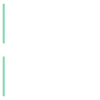

In [5]:
gapped = line2.difference(gap)
gapped

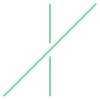

In [6]:
line1.union(gapped)

In [77]:
import pickle
with open('/home/ruben/tmp/hof3-demo-renderablelines.pcl', 'rb') as fp:
    rl = pickle.load(fp)
len(rl.lines)

2

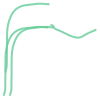

In [82]:
line1 = LineString([p.position for p in rl.lines[0].points])
line1_similar = LineString([[p.position[0]+.8, p.position[1]] for p in rl.lines[0].points])
line1_similar2 = LineString([[p.position[0]+.2, p.position[1]+3] for p in rl.lines[0].points])

line2 = LineString([p.position for p in rl.lines[1].points])

all_lines = [line1, line1_similar, line1_similar2, line2]

shapely.union_all(all_lines)


In [81]:
from typing import List


def remove_overlaps(line_strings: List[LineString], boundary=.3):
    resulting_geometries: List[shapely.BaseGeometry] = []
    for line in line_strings:
        if not len(resulting_geometries):
            resulting_geometries.append(line)
            continue

        current_shape = shapely.union_all(resulting_geometries)
        result = line.difference(current_shape.buffer(boundary))
        # if result.is_empty: # keep empty, so that we keep track of index of the lines
        #     continue
        resulting_geometries.append(result)
    return resulting_geometries
        

4 line


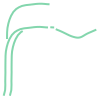

In [ ]:
clean_lines = remove_overlaps(all_lines, .3)
print(len(clean_lines), "line")
shapely.union_all(clean_lines)

In [99]:
# line3d_1 = LineString([[p.position[0], p.position[1], p.color.alpha] for p in rl.lines[0].points])
# line3d_2 = LineString([[p.position[0]+1, p.position[1], p.color.alpha] for p in rl.lines[0].points])
# shapely.union_all([line3d_1, line3d_2])
# shapely.difference(line3d_1, line3d_2.buffer(.3), axis=0) # axis does not exist

# Self intersection
This works different from intersection with another line. Thus, we would need to calculate this

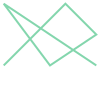

In [11]:
self_intersecting_line = LineString([[0,0], [2,2], [3,1], [1.5,0], [0,2], [3,0]])
self_intersecting_line

In [12]:
line1.is_simple, self_intersecting_line.is_simple

(True, False)

In [19]:
try:
    diff_line = shapely.ops.split(self_intersecting_line, self_intersecting_line)
except Exception as e:
    print("That trick does not work:", e)

That trick does not work: Input geometry segment overlaps with the splitter.


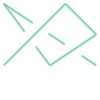

In [75]:
from shapely import MultiLineString, is_empty, is_simple

def linestring_to_segments(ls: LineString) -> List[LineString]:
    return [
        LineString([self_intersecting_line.coords[i], self_intersecting_line.coords[i+1]]) 
        for i in range(len(self_intersecting_line.coords)-1)
        ]

def split_line_at_self_intersection(linestring: LineString, boundary = .3):
    if linestring.is_simple:
        return linestring
    segments = linestring_to_segments(linestring)
    new_segments = split_at_self_intersection(segments, boundary_size=boundary)
    if len(new_segments) == 1:
        return new_segments[0]
    return MultiLineString(new_segments)    


def split_at_self_intersection(segments, new_segments = [], boundary_size = .3):
    if not len(segments):
        return new_segments
    
    segment = segments.pop(0)
    for ns in new_segments[:-1]: # assume there's no overlap with last one
        if segment.intersects(ns):
            #cut
            parts = segment.difference(ns.buffer(boundary_size))
            if type(parts) is LineString:
                if not parts.is_empty:
                    new_segments.append(parts)
                remaining_segments = segments
            elif type(parts) is MultiLineString:
                
                new_segments.append(parts.geoms[0]) # add the first part
                # prepend remaining bit, and calculate from there
                remaining_segments = [parts.geoms[1]]
                remaining_segments.extend(segments)

            return split_at_self_intersection(remaining_segments, new_segments, boundary_size)
            pass
    
    new_segments.append(segment)
    return split_at_self_intersection(segments, new_segments, boundary_size)

# MultiLineString(split_at_self_intersection(segments, boundary_size=.1))
split_line_at_self_intersection(self_intersecting_line, .3)

# Simplification

27 6


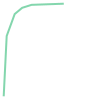

In [61]:
print(line1.coords.__len__(), line1.simplify(.15).coords.__len__())
line1.simplify(.15)